<a href="https://colab.research.google.com/github/poojasaxena/tensorflow-developer-zertificate-coursera/blob/main/running_application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%autosave 30 

Autosaving every 30 seconds


# Basics

## Import liberaries

In [2]:
import os
import sys
import string
import shutil
import logging
import random

import kaggle
import zipfile

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print(tf.__version__)
%matplotlib inline

2.6.0


In [3]:
from platform import python_version
print(python_version())

3.8.12


## Test GPU Access

In [6]:
import tensorflow as tf 
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


2021-10-19 11:19:59.482916: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
import tensorflow as tf
major_version = int(tf.__version__.split(".")[0])
if major_version >= 2:
    from tensorflow.python import _pywrap_util_port
    print("MKL enabled:", _pywrap_util_port.IsMklEnabled())
else:
    print("MKL enabled:", tf.pywrap_tensorflow.IsMklEnabled()) 

ImportError: cannot import name '_pywrap_util_port' from 'tensorflow.python' (/usr/local/lib/python3.8/site-packages/tensorflow/python/__init__.py)

In [8]:
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


## Setting up logger

In [4]:
script_path = os.environ.get("DirForPoolScripts")
sys.path.append(script_path)

In [5]:
from setup_basic_logger import setup_logger
logger = setup_logger(degree="INFO")

INFO:11:36:27 AM: logger <Logger test-logger (INFO)> has Disable::False


Help on function setup_logger in module setup_basic_logger:

setup_logger(degree, enable=True)
    setup a basic logger with degree=["DEBUG","INFO", "WARNING","ERROR"], 
    could be disable via 'enable' variable, default is enable



# Download Dataset from Kaggle

## in Google colab
* working [reference](https://colab.research.google.com/gist/corrieann/3abf2e79f833200d72b58ff10b1df39e/kaggle-api.ipynb)
* use this [reference](https://www.kaggle.com/general/74235)

In [9]:
#from google.colab import files
#files.upload()

In [10]:
 #! kaggle datasets list | grep 'cat'

In [11]:
#! kaggle competitions download -c "dogs-vs-cats"
#!kaggle competitions list -s health

## in Jupyter-notebook

In [6]:
base_dir = "/tmp/dogs_vs_cats/"

if os.path.exists(base_dir):
    print(f"For your info, basedir {base_dir} already exist.")
else:
    print("Basedir {base_dir} does not exist.")
    
fresh_start = input("Do you want to fresh start with downloading dataset? reply 'yes' or 'no': ").upper()

if "YES" in fresh_start:
    if not os.path.exists(base_dir):
        logger.error(f"The path {base_dir} does not exist.")
    else:
        logger.warning(f'Clearning {base_dir}, as you asked for!')
        shutil.rmtree(base_dir)
        logger.info("You are ready for fresh start!!")
else:
    logger.info('Enjoy working non-fresh!')

For your info, basedir /tmp/dogs_vs_cats/ already exist.
Do you want to fresh start with downloading dataset? reply 'yes' or 'no': no


INFO:11:36:32 AM: Enjoy working non-fresh!


In [14]:
from kaggle.api.kaggle_api_extended import KaggleApi

def upload_kaggle_dataset(kaggle_dataset_name, base_dir_name):
    """
    kaggle_dataset_name: name of the dataset to be downloaded
    base_dir_name: some directory where it suppose to be downloaded
    """
    change_to_tmp = "/"+base_dir.split("/")[1]+"/"
    os.chdir(change_to_tmp)

    if os.path.exists(base_dir_name):
        logger.info(f"Dataset {kaggle_dataset_name} is avalable in {base_dir_name} with content: \n {os.listdir(base_dir_name)}")
        return
    else:
        logger.debug("Authenticating kaggle API======")
        api=KaggleApi()
        api.authenticate()
        api.competition_download_files(kaggle_dataset_name)
    
        logger.debug("Authenticated, downloading Dataset =======")
        with zipfile.ZipFile(kaggle_dataset_name+'.zip', mode='r') as zip_ref:
            zip_ref.extractall(base_dir_name)
            zip_ref.close()
        logger.info(f"Dataset {kaggle_dataset_name} is downloaded in {base_dir_name} with content: \n {os.listdir(base_dir_name)}")

In [15]:
## Lets download the kaggle dataset
kaggle_dataset_name = "dogs-vs-cats"
upload_kaggle_dataset(kaggle_dataset_name, base_dir_name=base_dir)

INFO:10:20:45 AM: Dataset dogs-vs-cats is downloaded in /tmp/dogs_vs_cats/ with content: 
 ['sampleSubmission.csv', 'test1.zip', 'train.zip']


In [11]:
#upload_kaggle_dataset(kaggle_dataset_name="cat-breeds-dataset", base_dir_name="/tmp/cats")

# Preprocessing

## unzipping train/test dataset

In [16]:
## unzipped train/test directories
def unzip_sub_directories(train_zip_name, test_zip_name, base_dir_name): 
    
    ## Lets define our unzip directories names
    unzip_train_dir = os.path.join(base_dir_name, train_zip_name.split(".")[0])
    unzip_test_dir = os.path.join(base_dir_name, test_zip_name.split(".")[0])
    
    ## First checking it there are already unzipped directories existing 
    if os.path.exists(unzip_train_dir) and os.path.exists(unzip_test_dir):
        logger.warning(f'Unzipped directory of train/test exists in {base_dir_name}: \n {os.listdir(base_dir_name)}')
        return
    else:
        logger.info(f'Unzipping train/test directory in {base_dir_name} ======')

        ## Lets unzip the train/test zip files
        for zipped in [os.path.join(base_dir_name, train_zip_name), os.path.join(base_dir_name, test_zip_name)]:
            with zipfile.ZipFile(zipped, mode='r') as zip_ref:
                zip_ref.extractall(base_dir_name)
            zip_ref.close()
        
        logger.info(f'Finished, dataset exists in {base_dir_name} : \n {os.listdir(base_dir_name)}') 

In [17]:
## assign the train/test zip names 
sample,test_zip, train_zip = os.listdir(base_dir)

## unzip the train/test 
unzip_sub_directories(train_zip, test_zip, base_dir_name=base_dir)

INFO:10:21:06 AM: Unzipping train/test directory in /tmp/dogs_vs_cats/ ======
INFO:10:21:19 AM: Finished, dataset exists in /tmp/dogs_vs_cats/ : 
 ['sampleSubmission.csv', 'test1', 'test1.zip', 'train', 'train.zip']


## Check the unzipped data

In [18]:
sub_dir=["train", "test1"]
for sub in sub_dir:
    useful_files_in_train = [f for f in os.listdir(os.path.join(base_dir, sub)) if f.startswith('cat') or f.startswith("dog")]
    print(f"There are {len(useful_files_in_train)} images in {os.path.join(base_dir, sub)}")

There are 25000 images in /tmp/dogs_vs_cats/train
There are 0 images in /tmp/dogs_vs_cats/test1


## Create directory structure
- As there is none dog/cat labeled data in `/tmp/dogs_vs_cats/test1` folder, we will create `test` directory and create train/test/validation directories structures
- directory structure : `/tmp/dogs_vs_cats/train/cat&dog` vs `/tmp/dogs_vs_cat/validation/cat&do` `/tmp/dogs_vs_cat/test/cat&dog`

In [7]:
train_eval_dirs = ["train/cat", 'train/dog', 'eval/cat',  'eval/dog', 'test/cat', 'test/dog']

# base directories, in order for them to feed to Image_data_generator for preprocessing before feeding to CNN
base_train = os.path.join(base_dir, "train")
base_eval = os.path.join(base_dir, "eval")
base_test = os.path.join(base_dir, "test")

## train
base_train_cat = os.path.join(base_dir, train_eval_dirs[0])
base_train_dog = os.path.join(base_dir, train_eval_dirs[1])

## evaluate
base_eval_cat = os.path.join(base_dir, train_eval_dirs[2])
base_eval_dog = os.path.join(base_dir, train_eval_dirs[3])

## test
base_test_cat = os.path.join(base_dir, train_eval_dirs[4])
base_test_dog = os.path.join(base_dir, train_eval_dirs[5])


for dirs in train_eval_dirs:
    if not os.path.exists(os.path.join(base_dir, dirs)):
        os.makedirs(os.path.join(base_dir, dirs))
    else:
        print(f'The directories {dirs} exists already.')

The directories train/cat exists already.
The directories train/dog exists already.
The directories eval/cat exists already.
The directories eval/dog exists already.
The directories test/cat exists already.
The directories test/dog exists already.


## Seperate dog/cat data
- since all the data & cat dataset is in `/tmp/dogs_vs_dats/train` 
- we will seperate them it to `/tmp/dogs_vs_dats/train/dogs` and `/tmp/dogs_vs_cats/train/cats` 

In [20]:
def move_to_destination(origin, destination, image_name, split_dataset_percentage):

    ## first check if the origin directory exists
    if not os.path.exists(origin):
        logger.error(f"The path {origin} does not exist, existing.")
        return
    
    ## lets check if there is any data in origin to copy to destination
    elif len(os.listdir(origin))<=5:
        fname_dir=[file for file in os.listdir(origin) if os.path.isdir(os.path.join(origin,file))]
        fname_files=[file for file in os.listdir(origin) if os.path.isfile(os.path.join(origin,file))]
        logger.warning(f"There are {len(fname_dir)} {fname_dir} directory & {len(fname_files)} image dataset in {origin} to copy.")
        
        if len(os.listdir(destination))>0:
            logger.info(f"There is already {len(os.listdir(destination))} image dataset in {destination}.")
            return
        else:
            logger.info(f"Besides, there is {len(os.listdir(destination))} image dataest in {destination}")
            return
    else:
        ## Lets move the image dataset
        num_images = [f for f in os.listdir(origin) if f.endswith('jpg') & f.startswith(image_name)]
        logger.info(f"Out of {len(num_images)} {image_name} images in {origin}, {int(len(num_images)*float(split_dataset_percentage))} will be moved to {destination}")
    
        random_images = random.sample(num_images, int(len(num_images)*split_dataset_percentage))
        for image in random_images:      
            logger.debug(origin+'/'+image, destination+'/'+image)
            os.replace(origin+'/'+image, destination+'/'+image) 
            continue
        
        logger.info(f'    ====== Finished moving the file. There are {len(os.listdir(destination))} {image_name} examples in {destination}')

In [21]:
## Lets first move all data to base_train_cat, base_train_dog
origin_dir = os.path.join(base_dir, "train")
move_to_destination(origin=origin_dir, destination=base_train_cat, image_name="cat", split_dataset_percentage=1)
move_to_destination(origin=origin_dir, destination=base_train_dog, image_name="dog", split_dataset_percentage=1)

INFO:10:21:27 AM: Out of 12500 cat images in /tmp/dogs_vs_cats/train, 12500 will be moved to /tmp/dogs_vs_cats/train/cat
INFO:10:21:29 AM:     ====== Finished moving the file. There are 12500 cat examples in /tmp/dogs_vs_cats/train/cat
INFO:10:21:29 AM: Out of 12500 dog images in /tmp/dogs_vs_cats/train, 12500 will be moved to /tmp/dogs_vs_cats/train/dog
INFO:10:21:32 AM:     ====== Finished moving the file. There are 12500 dog examples in /tmp/dogs_vs_cats/train/dog


## Prepare validation/test dataset
- We will use the above function to prepare our test/validation dataset
- since all the dataset is in train, we will move 10% into test and 10% into validation

In [22]:
move_to_destination(origin=base_train_cat, destination=base_test_cat, image_name="cat",split_dataset_percentage=0.1)
move_to_destination(origin=base_train_dog, destination=base_test_dog, image_name="dog",split_dataset_percentage=0.1)
move_to_destination(origin=base_train_cat, destination=base_eval_cat, image_name="cat",split_dataset_percentage=0.1)
move_to_destination(origin=base_train_dog, destination=base_eval_dog, image_name="dog",split_dataset_percentage=0.1)

INFO:10:21:32 AM: Out of 12500 cat images in /tmp/dogs_vs_cats/train/cat, 1250 will be moved to /tmp/dogs_vs_cats/test/cat
INFO:10:21:32 AM:     ====== Finished moving the file. There are 1250 cat examples in /tmp/dogs_vs_cats/test/cat
INFO:10:21:32 AM: Out of 12500 dog images in /tmp/dogs_vs_cats/train/dog, 1250 will be moved to /tmp/dogs_vs_cats/test/dog
INFO:10:21:32 AM:     ====== Finished moving the file. There are 1250 dog examples in /tmp/dogs_vs_cats/test/dog
INFO:10:21:32 AM: Out of 11250 cat images in /tmp/dogs_vs_cats/train/cat, 1125 will be moved to /tmp/dogs_vs_cats/eval/cat
INFO:10:21:33 AM:     ====== Finished moving the file. There are 1125 cat examples in /tmp/dogs_vs_cats/eval/cat
INFO:10:21:33 AM: Out of 11250 dog images in /tmp/dogs_vs_cats/train/dog, 1125 will be moved to /tmp/dogs_vs_cats/eval/dog
INFO:10:21:33 AM:     ====== Finished moving the file. There are 1125 dog examples in /tmp/dogs_vs_cats/eval/dog


## Image Visualization

In [38]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

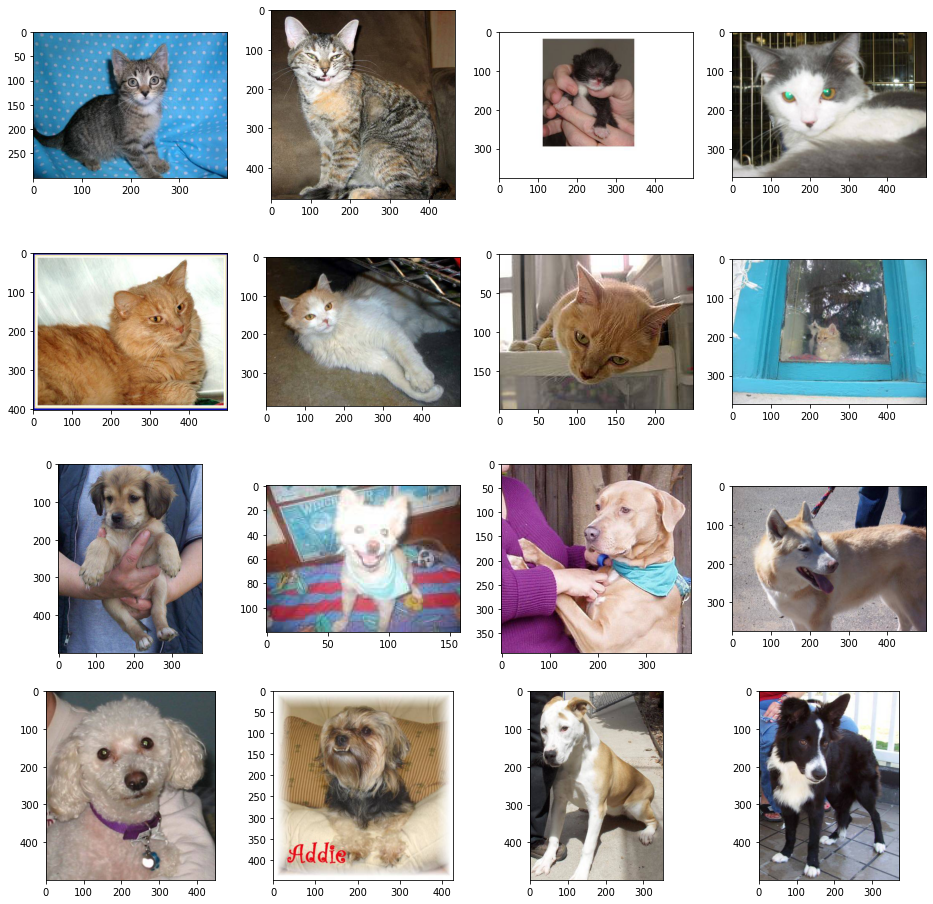

In [39]:
pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8
next_cat_pix = [os.path.join(base_train_cat, fname) 
                for fname in os.listdir(base_train_cat)[ pic_index-8:pic_index]]

next_dog_pix = [os.path.join(base_train_dog, fname) 
                for fname in os.listdir(base_train_dog)[ pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
      #sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

# Modeling

In [40]:
from tensorflow.keras import layers, models, optimizers

def create_model(activation_function, image_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=image_shape),
        layers.MaxPool2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPool2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPool2D((2,2)),
        
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPool2D((2,2)),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation=activation_function)        
    ])
    
    if activation_function=="sigmoid":
        loss_function = 'binary_crossentropy'
        metric_function="accuracy"
    elif activation_function == "softmax":
        loss_function = "sparse_categorical_crossentropy"
        metric_function = "sparse_categorical_accuracy"
    else:
        logger.warning(f"Given {activation_function} is not defined, loss_function and metrics are not known.")
        
    # compile the model
    model.compile(
        optimizer=optimizers.Adam(),
        loss=loss_function,
        metrics =[metric_function]
    )
    
    return model

In [41]:
cnn_model=create_model(activation_function="sigmoid", image_shape=(200,200,3))
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       7

2021-10-05 13:46:58.232897: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Preparation
Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit`, `evaluate_generator`, and `predict_generator`.

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(base_train,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(200, 200))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(base_eval,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (200, 200))

Found 20250 images belonging to 2 classes.
Found 2250 images belonging to 2 classes.


In [16]:
print(f"labels for each class in the train generator are: {train_generator.class_indices}")
print(f"labels for each class in the validation generator are: {validation_generator.class_indices}")

labels for each class in the train generator are: {'cat': 0, 'dog': 1}
labels for each class in the validation generator are: {'cat': 0, 'dog': 1}


## Model fitting

In [44]:
history_cnn = cnn_model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_steps=50,
                              verbose=2)

2021-10-05 13:53:04.024879: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
100/100 - 35s - loss: 0.6947 - accuracy: 0.5325 - val_loss: 0.6930 - val_accuracy: 0.4970
Epoch 2/50
100/100 - 35s - loss: 0.6697 - accuracy: 0.5945 - val_loss: 0.6666 - val_accuracy: 0.5990
Epoch 3/50
100/100 - 36s - loss: 0.6517 - accuracy: 0.6130 - val_loss: 0.8257 - val_accuracy: 0.5330
Epoch 4/50
100/100 - 37s - loss: 0.6155 - accuracy: 0.6505 - val_loss: 0.6406 - val_accuracy: 0.6310
Epoch 5/50
100/100 - 38s - loss: 0.6064 - accuracy: 0.6730 - val_loss: 0.6139 - val_accuracy: 0.6690
Epoch 6/50
100/100 - 37s - loss: 0.5734 - accuracy: 0.6925 - val_loss: 0.5605 - val_accuracy: 0.7070
Epoch 7/50
100/100 - 37s - loss: 0.5617 - accuracy: 0.7190 - val_loss: 0.5825 - val_accuracy: 0.7080
Epoch 8/50
100/100 - 37s - loss: 0.5264 - accuracy: 0.7360 - val_loss: 0.5591 - val_accuracy: 0.6970
Epoch 9/50
100/100 - 38s - loss: 0.5219 - accuracy: 0.7395 - val_loss: 0.5180 - val_accuracy: 0.7430
Epoch 10/50
100/100 - 38s - loss: 0.5077 - accuracy: 0.7573 - val_loss: 0.5073 - val_accura

# Evaluating model

## Plotting accuracy/loss 

In [48]:
import os
import sys

script_path = os.environ.get('DirForPoolScript')
sys.path.append(script_path)

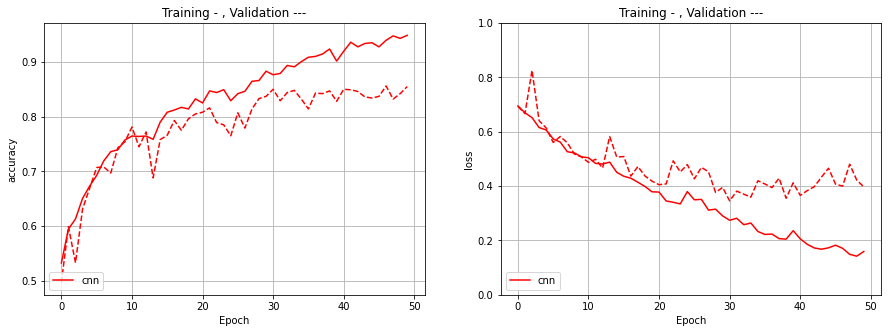

In [50]:
from ploting_script import plot_n_model
plot_n_model(num_history=1, name_history=[history_cnn], label_list=["cnn"],ylim_low=0)

## Accuracy on test data

In [53]:
# Use the validation generator without shuffle to easily compute additional metrics
test_gen_no_shuffle = test_datagen.flow_from_directory(
    base_test,
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary',
    shuffle=False)
print(f"labels for each class in the test generator are: {test_gen_no_shuffle.class_indices}")

Found 2500 images belonging to 2 classes.
labels for each class in the test generator are: {'cat': 0, 'dog': 1}


In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

y_true = test_gen_no_shuffle.classes
predictions_balanced = cnn_model.predict(test_gen_no_shuffle)
y_pred_balanced = np.where(predictions_balanced < 0.5, 0 , 1)

# Get the argmax (since softmax is being used)
#y_pred_balanced = np.argmax(predictions_balanced, axis=1)

print(f"Accuracy Score: {accuracy_score(y_true, y_pred_balanced)}")
print(f"Balanced Accuracy Score of balanced dataset: {balanced_accuracy_score(y_true, y_pred_balanced)}")

Accuracy Score: 0.856
Balanced Accuracy Score of balanced dataset: 0.8560000000000001


## Confusion Matrix

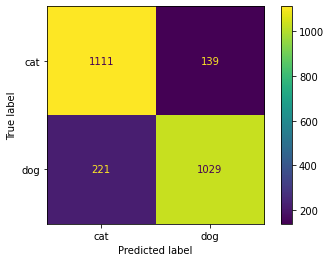

In [55]:
imbalanced_cm = confusion_matrix(y_true, y_pred_balanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['cat', 'dog']).plot(values_format='d')

## External image prediction

In [88]:
from keras.models import load_model
from keras.preprocessing import image

def load_image(img_path, show=False):
    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [133]:
def predict_new_image(model, image_name):
    
    # image path
    img_path = 'test_images/' + image_name

    if not os.path.exists(img_path):
        logger.error(f"{img_path} does not exist")
        return
    
    # load a single image
    new_image = load_image(img_path, show=True)
    pred = model.predict(new_image)
    
    if pred[0]>0.5:
        print(pred[0], " is a dog")    
    else:
        print(pred[0], " is a cat")

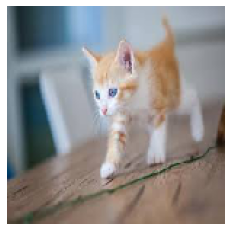

[0.05738512]  is a cat


In [141]:
predict_new_image(model=cnn_model, image_name="cat_04.jpeg")

In [ ]:
## Testing on uploaded images
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

# Saving the model

## json and h5

In [61]:
path_to_save_model="/Users/psaxena/Documents/weitebildung/saved_models/dog_cat_classifier/"

model_json = cnn_model.to_json()
with open(path_to_save_model+"model_dogcat_classifier_cnn_85acc_1021.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
cnn_model.save_weights(path_to_save_model+"model_dogcat_classifier_cnn_85acc_1021.h5")
cnn_model.save_weights(path_to_save_model+"model_dogcat_classifier_cnn_85acc_1021.h5")

## saving history

In [62]:
## saving history
try:
    import dill as pickle
except ImportError:
    import pickle
with open(path_to_save_model+'history_dogcat_classifier_cnn_85acc_1021.dict','wb') as file_pi:
    pickle.dump(history_cnn.history, file_pi)

# Data Augmentation

## Apply data augmentation

In [63]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255., 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
train_generator = train_datagen.flow_from_directory(base_train,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(200, 200))     
# --------------------
validation_generator =  test_datagen.flow_from_directory(base_eval,
                                                   batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (200, 200))

Found 20250 images belonging to 2 classes.
Found 2250 images belonging to 2 classes.


In [64]:
cnn_model_dataaugmentation=create_model(activation_function="sigmoid", image_shape=(200,200,3))
cnn_model_dataaugmentation.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 128)      

## Model fitting

In [68]:
history_cnn_dataaugmentation = cnn_model_dataaugmentation.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=80,
                              validation_steps=50,
                              verbose=2)

Epoch 1/80
100/100 - 40s - loss: 0.3884 - accuracy: 0.8150 - val_loss: 0.4328 - val_accuracy: 0.8070
Epoch 2/80
100/100 - 41s - loss: 0.3986 - accuracy: 0.8230 - val_loss: 0.3869 - val_accuracy: 0.8090
Epoch 3/80
100/100 - 42s - loss: 0.3806 - accuracy: 0.8315 - val_loss: 0.3763 - val_accuracy: 0.8060
Epoch 4/80
100/100 - 40s - loss: 0.3914 - accuracy: 0.8240 - val_loss: 0.4637 - val_accuracy: 0.7770
Epoch 5/80
100/100 - 39s - loss: 0.3607 - accuracy: 0.8457 - val_loss: 0.3557 - val_accuracy: 0.8300
Epoch 6/80
100/100 - 38s - loss: 0.4008 - accuracy: 0.8205 - val_loss: 0.3704 - val_accuracy: 0.8370
Epoch 7/80
100/100 - 38s - loss: 0.3646 - accuracy: 0.8375 - val_loss: 0.3607 - val_accuracy: 0.8260
Epoch 8/80
100/100 - 38s - loss: 0.3670 - accuracy: 0.8385 - val_loss: 0.3644 - val_accuracy: 0.8360
Epoch 9/80
100/100 - 38s - loss: 0.3587 - accuracy: 0.8425 - val_loss: 0.3410 - val_accuracy: 0.8420
Epoch 10/80
100/100 - 38s - loss: 0.3539 - accuracy: 0.8490 - val_loss: 0.3544 - val_accura

## plotting

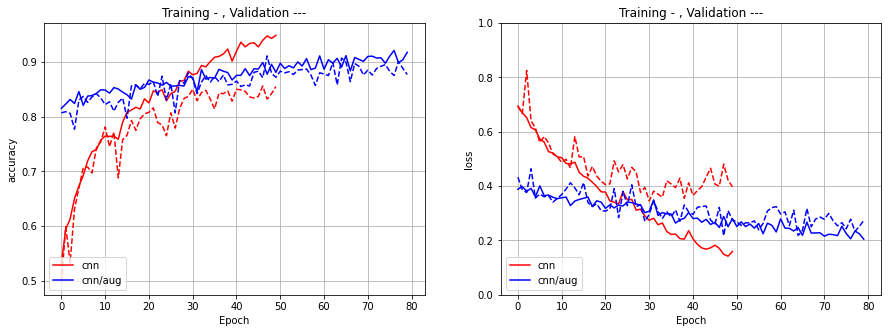

In [69]:
from ploting_script import plot_n_model
plot_n_model(num_history=2, name_history=[history_cnn, history_cnn_dataaugmentation], label_list=["cnn","cnn/aug"],ylim_low=0)

## Accuracy on test dataset

In [72]:
# Use the validation generator without shuffle to easily compute additional metrics
test_gen_no_shuffle = test_datagen.flow_from_directory(
    base_test,
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary',
    shuffle=False)
print(f"labels for each class in the test generator are: {test_gen_no_shuffle.class_indices}")

Found 2500 images belonging to 2 classes.
labels for each class in the test generator are: {'cat': 0, 'dog': 1}


In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

y_true = test_gen_no_shuffle.classes
predictions_balanced_aug = cnn_model_dataaugmentation.predict(test_gen_no_shuffle)
y_pred_balanced = np.where(predictions_balanced_aug < 0.5, 0 , 1)

print(f"Accuracy Score: {accuracy_score(y_true, y_pred_balanced)}")
print(f"Balanced Accuracy Score of balanced dataset: {balanced_accuracy_score(y_true, y_pred_balanced)}")

Accuracy Score: 0.8976
Balanced Accuracy Score of balanced dataset: 0.8976


## Confusion Matrix

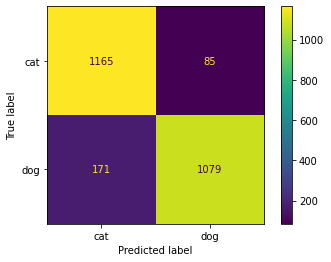

In [77]:
imbalanced_cm = confusion_matrix(y_true, y_pred_balanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['cat', 'dog']).plot(values_format='d')

## Saving model

In [80]:
model_json = cnn_model_dataaugmentation.to_json()
with open(path_to_save_model+"model_dogcat_classifier_cnn_augmentation_90acc_okt21.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
cnn_model_dataaugmentation.save_weights(path_to_save_model+"model_dogcat_classifier_cnn_augmentation_90acc_okt21.h5")
cnn_model_dataaugmentation.save_weights(path_to_save_model+"model_dogcat_classifier_cnn_augmentation_90acc_okt21.h5")

In [81]:
## saving history
try:
    import dill as pickle
except ImportError:
    import pickle
with open(path_to_save_model+'history_dogcat_classifier_cnn_augmentation_90acc_okt21','wb') as file_pi:
    pickle.dump(history_cnn_dataaugmentation.history, file_pi)

# Transfer Learning

## import Liberary 

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16

## Define model
**how to know the input image size for this model**
* just download model and ask for its inputs like here:
```
print(VGG16().inputs)
[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_5')>]
```

In [9]:
from tensorflow.keras import layers, models, optimizers

def create_model_from_transfer_learning(activation_function, image_shape):
    print(f"Input_shape for this vgg model is: {VGG16().inputs}")
    model = VGG16(include_top=False, input_shape=image_shape)
        
    ## lets mark loaded layers not trainable
    for layer in model.layers:
        layer.trainable = False
    
    ## add new classifier layers
    flat = layers.Flatten()(model.layers[-1].output)
    classes = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(flat)
    output = layers.Dense(1, activation=activation_function)(classes)
    model = models.Model(inputs=model.inputs, outputs=output)

    if activation_function=="sigmoid":
        loss_function = 'binary_crossentropy'
        metric_function="accuracy"
    elif activation_function == "softmax":
        loss_function = "sparse_categorical_crossentropy"
        metric_function = "sparse_categorical_accuracy"
    else:
        logger.warning(f"Given {activation_function} is not defined, loss_function and metrics are not known.")
        
    # compile the model
    model.compile(
        optimizer=optimizers.Adam(),
        loss=loss_function,
        metrics =[metric_function]
    )
    
    return model

In [10]:
vgg_model_tleaning=create_model_from_transfer_learning(activation_function="sigmoid", image_shape=(224,224,3))
vgg_model_tleaning.summary()

2021-10-19 11:36:44.039991: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Input_shape for this vgg model is: [<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______

In [11]:
## remains gthe same as above
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( rescale = 1.0/255., 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(base_train,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(base_eval,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (224, 224))

Found 20250 images belonging to 2 classes.
Found 2250 images belonging to 2 classes.


In [12]:
history_cnn_tlearning= vgg_model_tleaning.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=50,
                              epochs=50,
                              validation_steps=50,
                              verbose=1)

2021-10-19 11:36:50.995276: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
50/50 [==============================] - 189s 4s/step - loss: 0.7379 - accuracy: 0.7680 - val_loss: 0.3716 - val_accuracy: 0.8510
Epoch 2/50
50/50 [==============================] - 170s 3s/step - loss: 0.2892 - accuracy: 0.8780 - val_loss: 0.3837 - val_accuracy: 0.8560
Epoch 3/50
50/50 [==============================] - 164s 3s/step - loss: 0.3781 - accuracy: 0.8600 - val_loss: 0.2277 - val_accuracy: 0.9060
Epoch 4/50
50/50 [==============================] - 162s 3s/step - loss: 0.2915 - accuracy: 0.8780 - val_loss: 0.2036 - val_accuracy: 0.9160
Epoch 5/50
50/50 [==============================] - 164s 3s/step - loss: 0.2713 - accuracy: 0.8808 - val_loss: 0.2201 - val_accuracy: 0.9120
Epoch 6/50
50/50 [==============================] - 167s 3s/step - loss: 0.2557 - accuracy: 0.8960 - val_loss: 0.2477 - val_accuracy: 0.8950
Epoch 7/50
50/50 [==============================] - 170s 3s/step - loss: 0.2437 - accuracy: 0.8950 - val_loss: 0.2487 - val_accuracy: 0.9010
Epoch 8/50
50

## Plotting Accuracy vs Error

Help on function plot_n_model in module ploting_script:

plot_n_model(num_history=2, name_history=[], ylim_low=0.4, ylim_high=1.0, label_list=[], leg_loc='lower left', is_sparse_categorical=False, is_saved_history=False)
    num_history  : no of history to be plotted
    name_history : list of history name, ex [history_1, history_2]
    label_list   : list of label names, ex ['simple_model', 'model_cnn']
    y_lim_low    : lowest y scale
    y_lim_high   : highest y scale
    leg_loc      : location of legend ex: 'lower left', 'lower right', 'upper right', 'upper left'
    is_sparse_categorical : True, if sparse_categorical_accuracy is being used. 
    is_saved_history : if plotting saved history via pickle
    
                     @@ Saving part--
                     try:
                       import dill as pickle
                     except ImportError:
                        import pickle
                     with open('trainHistoryDict', 'wb') as file_pi:
                     

<Figure size 432x288 with 0 Axes>

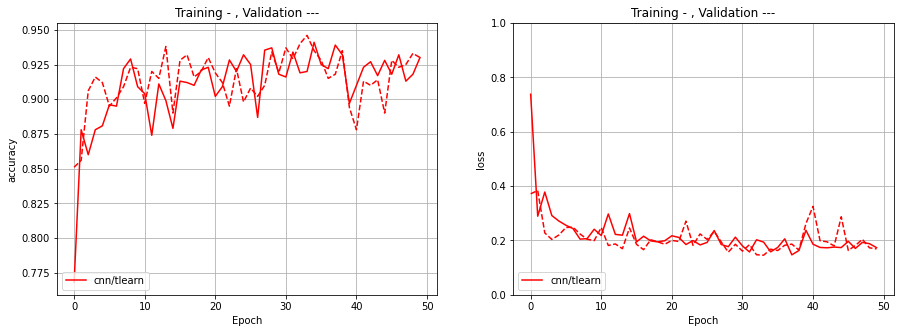

In [13]:
sys.path.append("/Users/psaxena/Documents/weitebildung/tensorflow-developer-zertificate-coursera/pool_common_scripts")
from ploting_script import plot_n_model
plot_n_model(num_history=1, name_history=[history_cnn_tlearning], label_list=["cnn/tlearn"],ylim_low=0)

## Accuracy on test dataset

In [14]:
# Use the validation generator without shuffle to easily compute additional metrics
test_gen_no_shuffle = test_datagen.flow_from_directory(
    base_test,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False)
print(f"labels for each class in the test generator are: {test_gen_no_shuffle.class_indices}")

Found 2500 images belonging to 2 classes.
labels for each class in the test generator are: {'cat': 0, 'dog': 1}


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

y_true = test_gen_no_shuffle.classes
predictions_balanced = vgg_model_tleaning.predict(test_gen_no_shuffle)
y_pred_balanced = np.where(predictions_balanced < 0.5, 0 , 1)

# Get the argmax (since softmax is being used)
#y_pred_balanced = np.argmax(predictions_balanced, axis=1)
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_balanced)}")
print(f"Balanced Accuracy Score of balanced dataset: {balanced_accuracy_score(y_true, y_pred_balanced)}")

Accuracy Score: 0.9404
Balanced Accuracy Score of balanced dataset: 0.9403999999999999


## Confusion Matrix

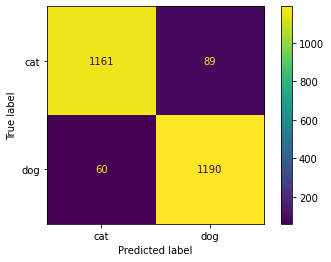

In [17]:
imbalanced_cm = confusion_matrix(y_true, y_pred_balanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['cat', 'dog']).plot(values_format='d')

## Saving Model

In [18]:
path_to_save_model="/Users/psaxena/Documents/saved_tained_models/dog_cat_classifier/"

model_json = vgg_model_tleaning.to_json()
with open(path_to_save_model+"model_dogcat_classifier_vgg_tLearn_95acc_okt21.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
vgg_model_tleaning.save_weights(path_to_save_model+"model_dogcat_classifier_vgg_tLearn_95acc_okt21.h5")
vgg_model_tleaning.save_weights(path_to_save_model+"model_dogcat_classifier_vgg_tLearn_95acc_okt21.h5")

In [19]:
## saving history
try:
    import dill as pickle
except ImportError:
    import pickle
with open(path_to_save_model+'history_dogcat_classifier_vgg_tLearn_95acc_okt21','wb') as file_pi:
    pickle.dump(history_cnn_tlearning.history, file_pi)

# Visualizing intermediate Representation

/var/folders/6n/xskqb5954jsfxw29ddrrqp74tqq6_x/T/ipykernel_40268/177256543.py:58: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


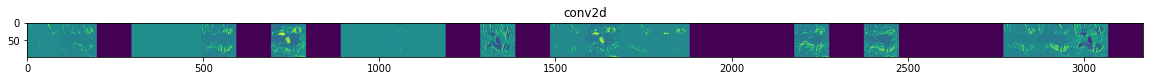

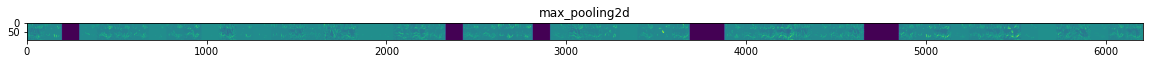

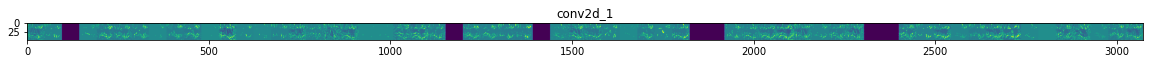

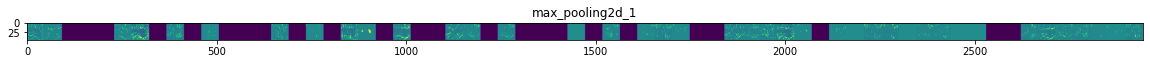

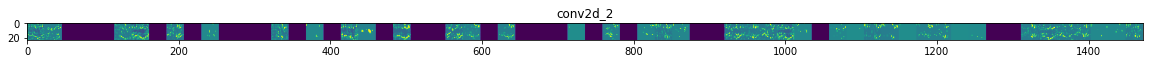

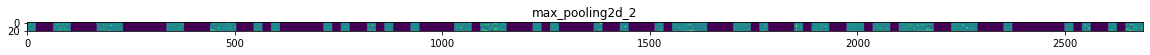

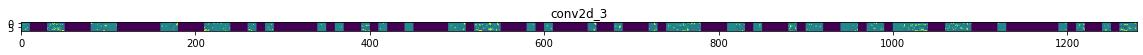

In [83]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in cnn_model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = cnn_model.input, outputs = successive_outputs)

train_cat_fnames = os.listdir( base_train_cat )
train_dog_fnames = os.listdir( base_train_dog )

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(base_train_cat, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(base_train_dog, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(200, 200))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in cnn_model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

# Cleanup

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)